In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
import sys
sys.path.append(r'/media/rich/Home_Linux_partition/github_repos/')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
from time import time

from tfrecord.torch.dataset import TFRecordDataset

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers
from basic_neural_processing_modules import misc

In [5]:
def load_data(dir_load, fileName_load, path_load=None):
    from pathlib import Path
    import scipy.io
    if path_load is None:
        dir_load = Path(dir_load).resolve()
        fileName_load = fileName_load
        path_load = dir_load / fileName_load

    dat = scipy.io.loadmat(path_load)
    return dat

In [6]:
def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("no GPU available. Using CPU.")
    else:
        print("GPU is enabled.")

    return device

In [7]:
def get_output_size(list_of_layers, n_inputs):
    for layer in list_of_layers:
#         if type(layer) == nn.Linear:
#             n_inputs = 
        if type(layer) == nn.Conv1d:
            n_inputs = conv_len_1d(n_inputs, layer)
        if type(layer) == nn.AvgPool1d:
            n_inputs = n_inputs // layer.kernel_size[0]
        
        return n_inputs

In [8]:
def conv_len_1d(in_length, layer):
    return int((in_length - layer.kernel_size[0] + layer.padding[0]*2)//layer.stride[0] +1)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # First define the layers.
        self.conv1 = nn.Conv1d(n_electrodes, 100, kernel_size=20, stride=2, padding=10)
        self.pool1 = nn.AvgPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(self.conv1.out_channels, 80, kernel_size=20, stride=1, padding=10)
        self.pool2 = nn.AvgPool1d(kernel_size=2)
        self.conv3 = nn.Conv1d(self.conv2.out_channels, 35, kernel_size=20, stride=1, padding=10)
        self.pool3 = nn.AvgPool1d(kernel_size=1)
#         linear_in_size = get_output_size([self.conv1, self.conv2, self.pool1, self.conv3, self.pool2], win_len)
        self.fc1 = nn.Linear(int((conv_len_1d(conv_len_1d(conv_len_1d(win_len, self.conv1) // self.pool1.kernel_size[0], self.conv2) // self.pool2.kernel_size[0] , self.conv3) // self.pool3.kernel_size[0]) * self.conv3.out_channels), n_letters * 20)
#         self.fc1 = nn.Linear(int((conv_len_1d(conv_len_1d(win_len, self.conv1) // self.pool1.kernel_size[0], self.conv2) // self.pool2.kernel_size[0]) * self.conv2.out_channels), n_letters * 5)
        self.fc2 = nn.Linear(self.fc1.out_features, n_letters * win_len)

    def forward(self, x):
#         print(x.shape)
        x = self.conv1(x)
        x = F.relu(x)
#         print(x.shape)
        x = self.pool1(x)

#         print(x.shape)
        x = self.conv2(x)
        x = F.relu(x)
#         print(x.shape)
        x = self.pool2(x)
            
#         print(x.shape)
        x = self.conv3(x)
        x = F.relu(x)
#         print(x.shape)
        x = self.pool3(x)

#         print(x.shape)
        x = x.view(x.shape[0], x.shape[1]*x.shape[2]) 
#         print(x.shape)
        x = self.fc1(x)
#         print(x.shape)
        x = F.relu(x)
        x = self.fc2(x)
#         print(x.shape)
        # x = F.softmax(x)

        return x

In [46]:
#define which datasets to process
dataDirs = ['t5.2019.05.08',
            't5.2019.11.25',
            't5.2019.12.09',
            't5.2019.12.11',
            't5.2019.12.18',
            't5.2019.12.20',
            't5.2020.01.06',
            't5.2020.01.08',
            't5.2020.01.13',
#             't5.2020.01.15'
           ]
cvParts = ['HeldOutBlocks', 'HeldOutTrials']

n_epochs = 4
n_days = len(dataDirs)
n_bats = 20
batch_size = 256
val_fraction = 0.2

win_len = 500

n_electrodes = 192
n_letters = 32

dir_folders = Path(r'/media/rich/bigSSD/NMA_data/Willet_data/Datasets/').resolve()

DEVICE = set_device()
net = Net().to(DEVICE)
for ii, layer in enumerate(net.parameters()):
    if type(layer) == nn.Linear:
        nn.init.xavier_uniform_(layer, gain=nn.init.calculate_gain('relu'))
criterion_letters = nn.CrossEntropyLoss()
criterion_onsets = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), 
                             lr=0.0002, 
#                              betas=(0.9, 0.999), 
#                              eps=1e-08, 
                             weight_decay=0.0001, 
                             amsgrad=False
                            )

GPU is enabled.


In [ ]:
loss_train_rolling = []
loss_test_rolling = []
accuracy_test_rolling = []
%matplotlib notebook
# fig1, axs1 = plt.subplots()
# fig2, axs2 = plt.subplots()
for epoch in tqdm(range(n_epochs)):
    
    for i_bat, bat_num in enumerate(tqdm(torch.randperm(n_bats))):
        print(f'(bat num {bat_num}), (bat iter {i_bat})')

        for i_day, day_num in enumerate(tqdm(torch.randperm(n_days))):
            print(f'using day: {dataDirs[day_num]}, (day num {day_num}), (day iter {i_day})')

    #         for i_bat, bat_num in enumerate(tqdm(torch.randperm(n_bats))):
    #             print(f'(bat num {bat_num}), (bat iter {i_bat})')
            dir_load = dir_folders / dataDirs[day_num] / cvParts[0] / (dataDirs[day_num]+r'_syntheticSentences') / (f'bat_{bat_num}.tfrecord')

            dataset = TFRecordDataset(dir_load,
                                      index_path=None,
            #                           description
                                     )
            loader = torch.utils.data.DataLoader(dataset, 
                                                 batch_size=batch_size, 
                                                 num_workers=0,
                                                 pin_memory=True,
                                                )

            ## currently, training validation fraction will just be the last few sentences in each batch
            idx_train = np.arange(0, np.round(batch_size * (1-val_fraction)))
            idx_val = np.arange(np.round(batch_size * (1-val_fraction)), batch_size)

#             for i_data, data in enumerate(loader):
            data = list(iter(loader))[0]
            minibatch_size = data['labels'].shape[0]
#             if minibatch_size < 10:
#                 continue

            idx_train = np.arange(0, np.round(minibatch_size * (1-val_fraction)))
            idx_val = np.arange(np.round(minibatch_size * (1-val_fraction)), minibatch_size)

            rs_shape = [data['inputs'].shape[0], int(data['inputs'].shape[1] / n_electrodes), n_electrodes]
            inputs_rs = torch.reshape(data['inputs'], rs_shape).to(DEVICE)
            rs_shape = [data['labels'].shape[0], int(data['labels'].shape[1] / n_letters), n_letters]
            labels_rs = torch.reshape(data['labels'], rs_shape).to(DEVICE)

#                 inputs_train = inputs_rs[idx_train]
#                 labels_train = labels_rs[idx_train]
#                 inputs_val = inputs_rs[idx_val]
#                 labels_val = labels_rs[idx_val]

            if i_day == 0:
#                 inputs_train = inputs_rs[idx_train][..., None]
#                 labels_train = labels_rs[idx_train][..., None]
#                 inputs_val = inputs_rs[idx_val][..., None]
#                 labels_val = labels_rs[idx_val][..., None]
                
                inputs_train = inputs_rs[idx_train]
                labels_train = labels_rs[idx_train]
                inputs_val = inputs_rs[idx_val]
                labels_val = labels_rs[idx_val]
            else:
#                 inputs_train = torch.cat((inputs_train, inputs_rs[idx_train][..., None]), dim=2)
#                 labels_train = torch.cat((labels_train, labels_rs[idx_train][..., None]), dim=2)
#                 inputs_val = torch.cat((inputs_val, inputs_rs[idx_val][..., None]), dim=2)
#                 labels_val = torch.cat((labels_val, labels_rs[idx_val][..., None]), dim=2)
                
                inputs_train = torch.cat((inputs_train, inputs_rs[idx_train]), dim=1)
                labels_train = torch.cat((labels_train, labels_rs[idx_train]), dim=1)
                inputs_val = torch.cat((inputs_val, inputs_rs[idx_val]), dim=1)
                labels_val = torch.cat((labels_val, labels_rs[idx_val]), dim=1)
                
            
            
        for i_slice, idx_slice_mid in enumerate(torch.randperm(inputs_train.shape[1] - int(win_len*1.5))+int(win_len*0.6)):
            # slice and permute the dimensions so that it follows pytorch nn.Conv1d convention: [N (batches) , C (channels), L (length)]
            inputs_train_slice = inputs_train[:, idx_slice_mid - int(win_len/2) : idx_slice_mid + int(win_len/2), :].permute((0,2,1))
            labels_train_slice = labels_train[:, idx_slice_mid - int(win_len/2) : idx_slice_mid + int(win_len/2), :].permute((0,2,1))
            inputs_val_slice = inputs_val[:, idx_slice_mid - int(win_len/2) : idx_slice_mid + int(win_len/2), :].permute((0,2,1))
            labels_val_slice = labels_val[:, idx_slice_mid - int(win_len/2) : idx_slice_mid + int(win_len/2), :].permute((0,2,1))
            
            inputs_train_slice = inputs_train_slice + torch.randn_like(inputs_train_slice)/2


            optimizer.zero_grad()
            y_train = net(inputs_train_slice).reshape(inputs_train_slice.shape[0], n_letters, win_len)
            loss_train = criterion_letters(y_train[:, :-1, 350:], torch.argmax(labels_train_slice[:, :-1, 350:], axis=1)) + criterion_onsets(y_train[:,-1,350:], labels_train_slice[:,-1,350:])
            loss_train.backward()
            optimizer.step()


            if i_slice%100 == 0:
                loss_train_rolling.append(loss_train.item())
                
                with torch.no_grad():
                    y_test = net(inputs_val_slice).reshape(inputs_val_slice.shape[0], n_letters, win_len)
                    predictions = torch.argmax(y_test[:, :-1, 350:], axis=1)
                    y_test_true_labels = torch.argmax(labels_val_slice[:, :-1, 350:], axis=1)
                    loss_test = criterion_letters(y_test[:, :-1, 350:], y_test_true_labels) + criterion_onsets(y_test[:,-1,350:], labels_val_slice[:,-1,350:])
                    loss_test_rolling.append(loss_test.item())
                    accuracy = torch.sum((predictions == y_test_true_labels).float()) / y_test_true_labels.nelement()
                    accuracy_test_rolling.append(accuracy.item())

#                 axs1.clear();
#                 axs1.plot(loss_train_rolling);
#                 axs1.plot(loss_test_rolling);
#                 axs1.plot()
#                 fig1.canvas.draw()

#                 axs2.clear();
#                 axs2.plot(accuracy_test_rolling);
#                 axs2.plot()
#                 fig2.canvas.draw()
#                         plt.draw();
#                         fig.clf()
#                 plt.pause(0.001);

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

(bat num 0), (bat iter 0)


  0%|          | 0/9 [00:00<?, ?it/s]

using day: t5.2020.01.13, (day num 8), (day iter 0)
using day: t5.2019.12.18, (day num 4), (day iter 1)
using day: t5.2020.01.06, (day num 6), (day iter 2)
using day: t5.2020.01.08, (day num 7), (day iter 3)
using day: t5.2019.12.20, (day num 5), (day iter 4)
using day: t5.2019.05.08, (day num 0), (day iter 5)
using day: t5.2019.12.11, (day num 3), (day iter 6)
using day: t5.2019.11.25, (day num 1), (day iter 7)
using day: t5.2019.12.09, (day num 2), (day iter 8)


In [57]:
def save_net_and_params(net, optimizer, dir_save=None, fileName_net='net.pth', fileName_params='params.pth'):
    from pathlib import Path
    dir_save = Path(dir_save).resolve()
    path_net = dir_save / fileName_net
    path_params = dir_save / fileName_params
    
    state_dict = {
        'net_params': net.state_dict(),
        'optimizer_params': optimizer.state_dict(),
    }
    
    torch.save(net, path_net)
    torch.save(state_dict, path_params)

In [58]:
from pathlib import Path

dir_save = Path(r'/media/rich/Home_Linux_partition/github_repos/NMA-project/CNN_models/20210817_a')

save_net_and_params(net, optimizer, dir_save)

In [10]:
# load

# net = torch.load(PATH)

state_dict = torch.load(r'/media/rich/Home_Linux_partition/github_repos/NMA-project/CNN_models/20210817_a/params.pth')
net.load_state_dict(state_dict['net_params'])

<All keys matched successfully>

In [12]:
import scipy.stats
import scipy.signal

In [13]:
for ii, val in enumerate(net.parameters()):
    if ii==2:
        test = val.cpu().detach()

In [14]:
test.shape

torch.Size([80, 100, 20])

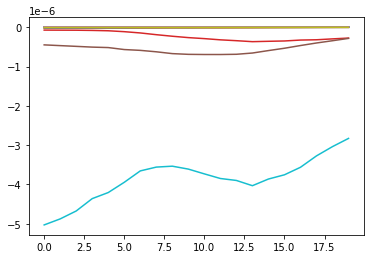

In [15]:
test.shape
plt.figure()
plt.plot(test[18][0:10].T);
# plt.imshow(
# #             scipy.stats.zscore(test[2], axis=1),
#             test[5],
#             aspect='auto',
#             interpolation='none'
#           )

<IPython.core.display.Javascript object>


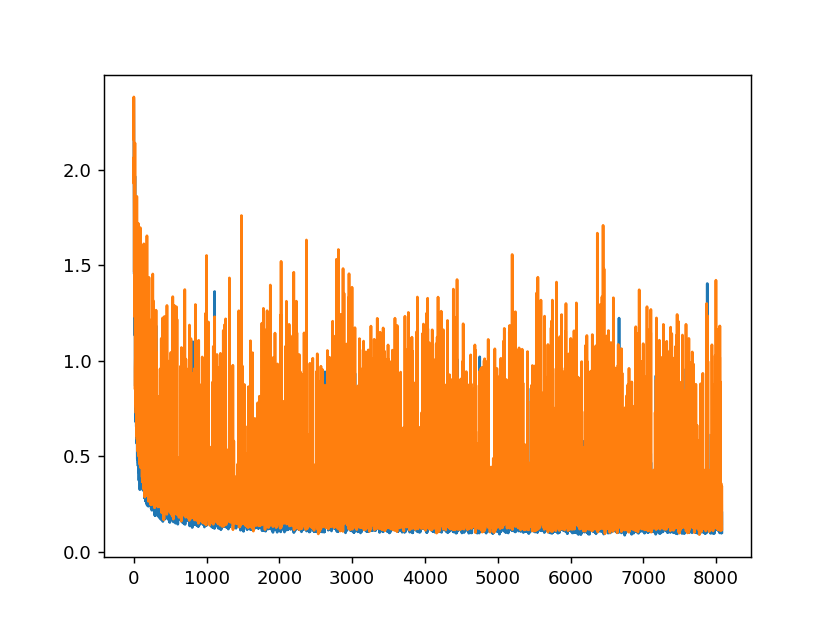

<IPython.core.display.Javascript object>


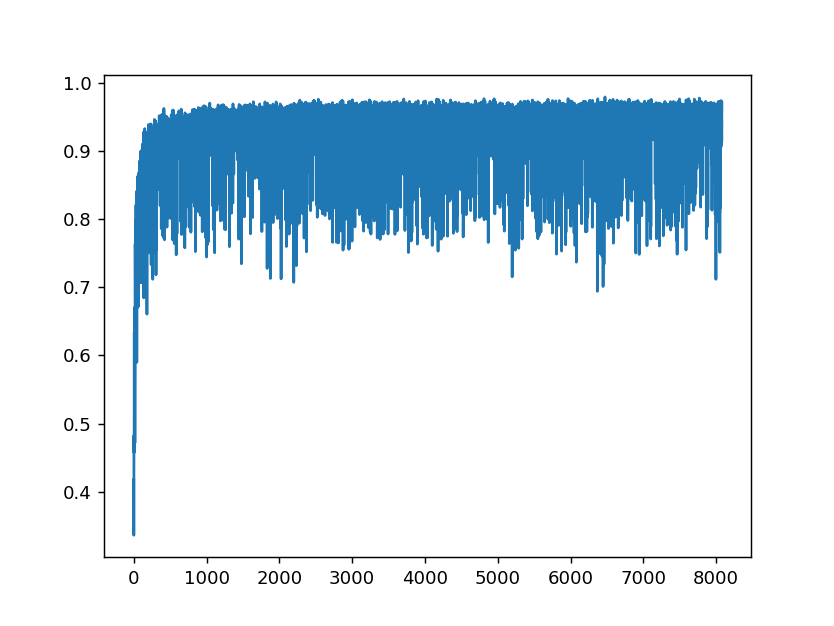

In [55]:
fig, axs = plt.subplots()
axs.plot(loss_train_rolling)
axs.plot(loss_test_rolling)

fig, axs = plt.subplots()
axs.plot(accuracy_test_rolling)


In [79]:
y_train.shape

torch.Size([205, 32, 500])

In [37]:
plt.figure()
# plt.imshow(y_train[0].cpu().detach().numpy()[:,300:-100])
plt.imshow(y[0].cpu().detach().numpy()[:,350:])

plt.figure()
plt.imshow(labels_train_slice[0].cpu().detach().numpy()[:,350:])

<IPython.core.display.Javascript object>

NameError: name 'y' is not defined

In [98]:
labels_val_slice.shape

torch.Size([51, 32, 500])

In [40]:
import time

<IPython.core.display.Javascript object>


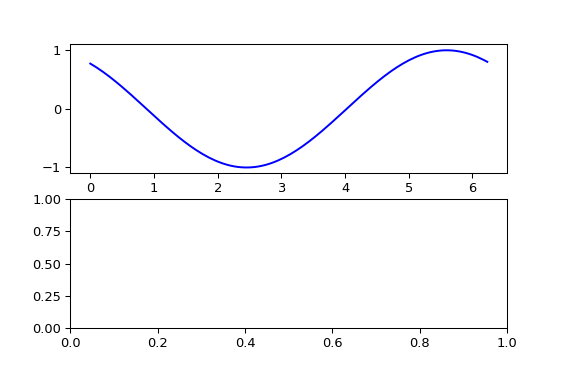

In [98]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook
# plt.ion()
fig, axes = plt.subplots(2)
camera = Camera(fig)
t = np.linspace(0, 2 * np.pi, 128, endpoint=False)
# t = np.array([1,2])
for i in t:
#     axes[0].clear()
    axes[0].plot(t, np.sin(t + i), color='blue')
#     axes[1].plot(t, np.sin(t - i), color='blue')
    camera.snap()
    
animation = camera.animate(10)  
# animation.save('celluloid_subplots.gif', writer = 'imagemagick')

In [93]:
 np.sin(t + i)

array([ 0.14112001, -0.7568025 ])

<IPython.core.display.Javascript object>


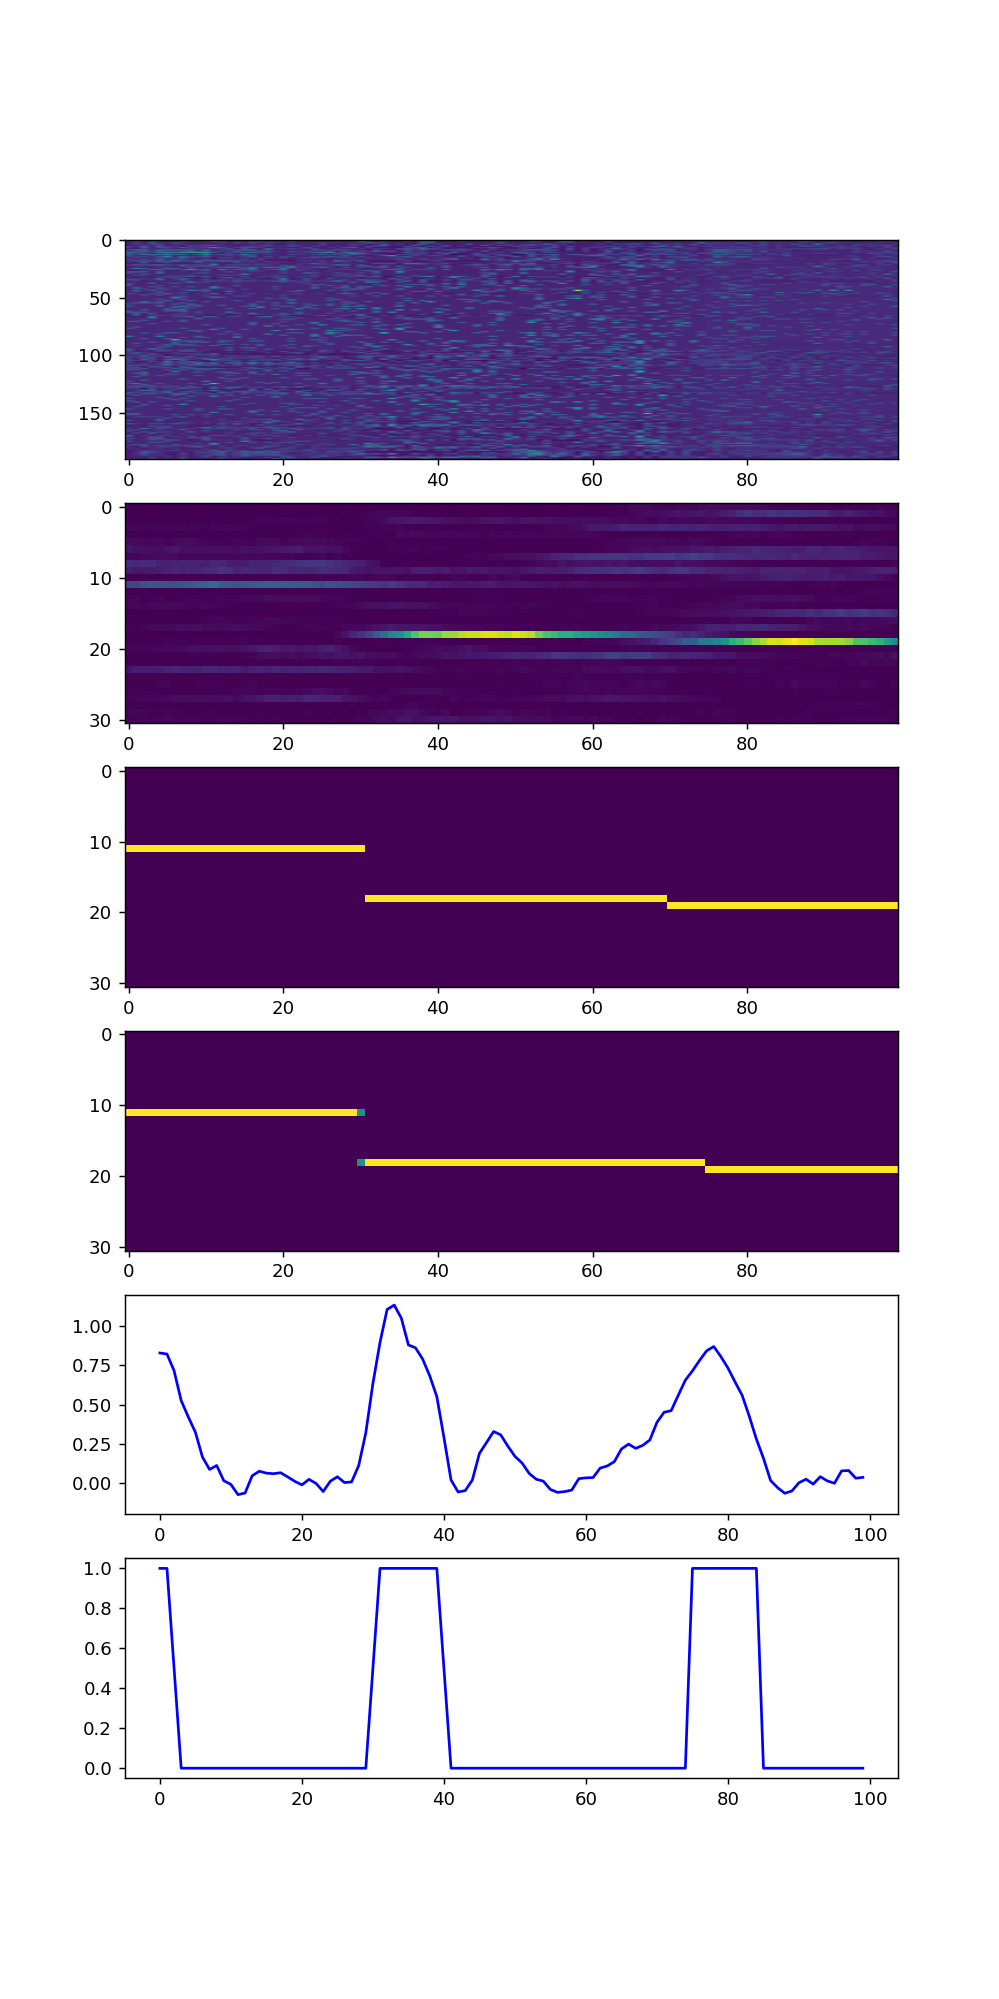

In [43]:
from celluloid import Camera
import matplotlib.animation as manimation

dataDirs = [
#             't5.2019.05.08',
#             't5.2019.11.25',
#             't5.2019.12.09',
#             't5.2019.12.11',
#             't5.2019.12.18',
#             't5.2019.12.20',
#             't5.2020.01.06',
#             't5.2020.01.08',
            't5.2020.01.13',
#             't5.2020.01.15'
           ]
cvParts = ['HeldOutBlocks', 'HeldOutTrials']

bat_num = 0
day_num = 0

dir_load = dir_folders / dataDirs[day_num] / cvParts[0] / (dataDirs[day_num]+r'_syntheticSentences') / (f'bat_{bat_num}.tfrecord')
dataset = TFRecordDataset(dir_load,
                      index_path=None,
#                           description
                     )
loader = torch.utils.data.DataLoader(dataset, 
                                 batch_size=batch_size, 
                                 num_workers=0,
                                 pin_memory=True,
                                )

data = list(iter(loader))[0]

rs_shape = [data['inputs'].shape[0], int(data['inputs'].shape[1] / n_electrodes), n_electrodes]
inputs_rs = torch.reshape(data['inputs'], rs_shape).to(DEVICE)
rs_shape = [data['labels'].shape[0], int(data['labels'].shape[1] / n_letters), n_letters]
labels_rs = torch.reshape(data['labels'], rs_shape).to(DEVICE)
    
%matplotlib notebook
fig, axs = plt.subplots(6, figsize=(10,20))
camera = Camera(fig)
for i_slice, idx_slice_mid in enumerate(np.arange(inputs_rs.shape[1] - int(win_len*1.5))+int(win_len*0.6)):
# for i_slice, idx_slice_mid in enumerate(np.arange(20)+500):

    inputs_rs_slice = inputs_rs[:, idx_slice_mid - int(win_len/2) : idx_slice_mid + int(win_len/2), :].permute((0,2,1))
    labels_rs_slice = labels_rs[:, idx_slice_mid - int(win_len/2) : idx_slice_mid + int(win_len/2), :].permute((0,2,1))

    y = net(inputs_rs_slice).reshape(inputs_rs_slice.shape[0], n_letters, win_len)
    y_oneHot = torch.nn.functional.one_hot(torch.argmax(y[0][:-1,350:].cpu().detach(), axis=0), 31).T

#     y_running[:, idx_slice_mid - int(win_len/2) : idx_slice_mid + int(win_len/2)] = y_running[:, idx_slice_mid - int(win_len/2) : idx_slice_mid + int(win_len/2)] + y

#     axs[0].clear();
    axs[0].imshow(inputs_rs_slice[0].cpu().detach().numpy()[:-1,350:], aspect='auto');
#     axs[1].clear();
    axs[1].imshow(y[0].cpu().detach().numpy()[:-1,350:]**2,
#                   vmin=-2, vmax=10,
                  aspect='auto', interpolation='none'
                 );
#     axs[2].clear();
    axs[2].imshow(y_oneHot, aspect='auto')
    axs[3].imshow(labels_rs_slice[0].cpu().detach().numpy()[:-1,350:], aspect='auto', interpolation='none')
#     axs[3].clear();
    axs[4].plot(y[0].cpu().detach().numpy()[-1,350:], 'b')
    axs[4].set_ylim([-0.2,1.2])
#     axs[4].clear();
    axs[5].plot(labels_rs_slice[0].cpu().detach().numpy()[-1,350:], 'b')
    camera.snap()
#     fig.canvas.draw()
#     plt.pause(0.001);

animation = camera.animate(33)  


In [44]:
animation.save('/media/rich/Home_Linux_partition/github_repos/NMA-project/CNN_models/20210817_a/animation.mp4', writer = 'ffmpeg')

<IPython.core.display.Javascript object>


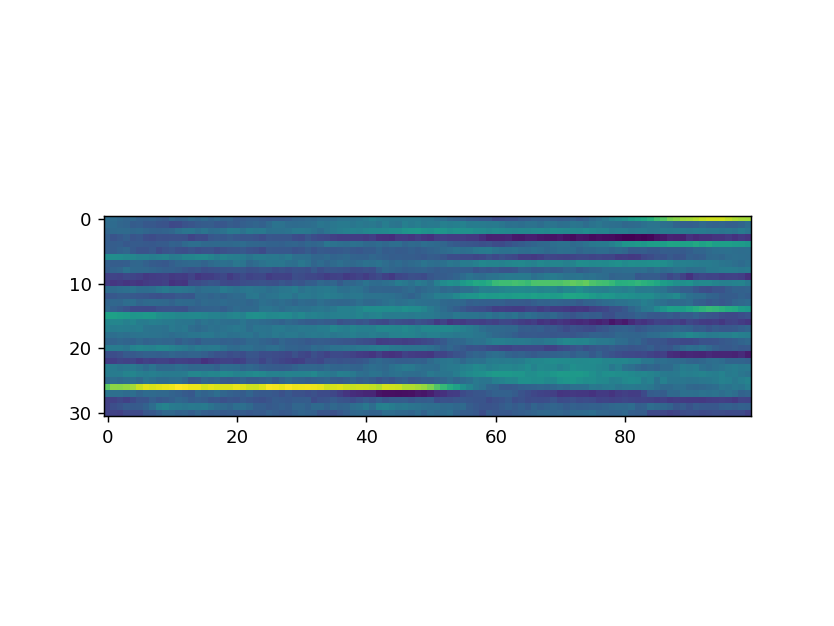

In [27]:
tmp = y[0][:-1,300:-100].cpu().detach().numpy()
tmp = torch.nn.functional.one_hot()
plt.figure()
plt.imshow(y[0][:-1,300:-100].cpu().detach().numpy())

<IPython.core.display.Javascript object>


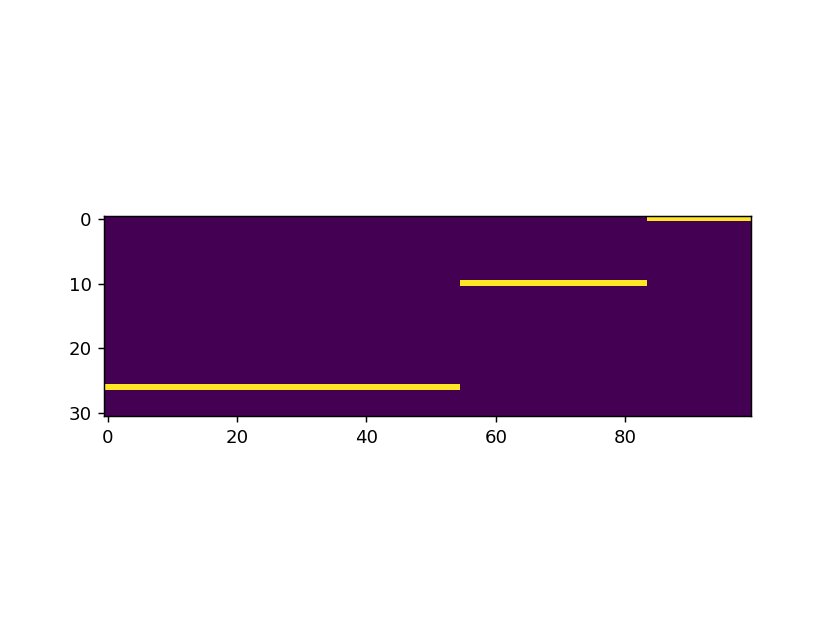

In [40]:
# tmp = torch.nn.functional.one_hot(torch.tensor([2,3]),10)
tmp = torch.nn.functional.one_hot(torch.argmax(y[0][:-1,300:-100].cpu().detach(), axis=0), 31).T
tmp.shape

plt.figure()
plt.imshow(tmp.T)

<IPython.core.display.Javascript object>


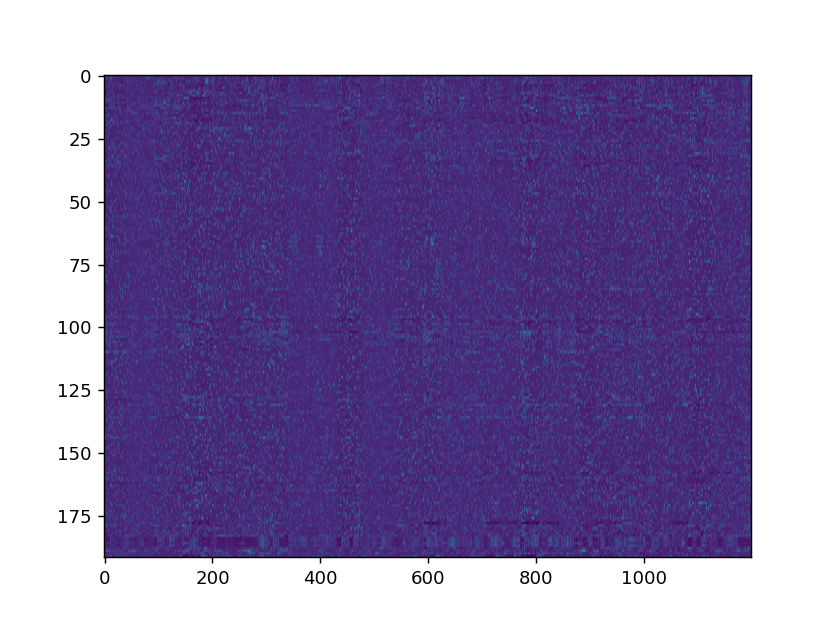

In [562]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(inputs_rs[0].T, aspect='auto')